Run on NERSC

Look into different masks including Aaron Meisner's pixel bitmask

In [1]:
from __future__ import division, print_function
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
import healpy as hp

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

--------
## DR7

In [3]:
# Randoms
randoms = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000.fits'))
# WISE geometric mask
catmask = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_wisemask.fits'))
# WISE pixel bitmask
pixmask = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_pixmask.npy'))

In [4]:
blobmask_bad = (randoms['MASKBITS'] & 2**1 > 0) # No BRIGHTSTARINBLOB
catmask_bad = np.copy(catmask['wisemask'])
# Pixel mask: not-primary and "resolved galaxy" are not masked
pixmask_bad = (pixmask!=0) & (pixmask!=(2**6)) & (pixmask!=(2**9))

__Individual masks__

In [5]:
print('BRIGHTSTARINBLOB')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(blobmask_bad)/len(randoms)*100))
print('WISE geometric mask')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(catmask_bad)/len(randoms)*100))
print('WISE pixel bitmask')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(pixmask_bad)/len(randoms)*100))

BRIGHTSTARINBLOB
Fraction of masked objects: 0.95%
WISE geometric mask
Fraction of masked objects: 2.71%
WISE pixel bitmask
Fraction of masked objects: 2.36%


__Combining the masks__

In [6]:
mask_bad = np.copy(blobmask_bad)
print('BRIGHTSTARINBLOB')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(randoms)*100))

mask_bad = blobmask_bad | catmask_bad
print('BRIGHTSTARINBLOB + WISE geometric')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(randoms)*100))

mask_bad = blobmask_bad | pixmask_bad
print('BRIGHTSTARINBLOB + WISE pixel')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(randoms)*100))

mask_bad = blobmask_bad | catmask_bad | pixmask_bad
print('BRIGHTSTARINBLOB + WISE geometric + WISE pixel')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(randoms)*100))

BRIGHTSTARINBLOB
Fraction of masked objects: 0.95%
BRIGHTSTARINBLOB + WISE geometric
Fraction of masked objects: 3.05%
BRIGHTSTARINBLOB + WISE pixel
Fraction of masked objects: 2.89%
BRIGHTSTARINBLOB + WISE geometric + WISE pixel
Fraction of masked objects: 4.28%


In [7]:
print('BRIGHTSTARINBLOB + WISE geometric + WISE pixel')
mask_bad = blobmask_bad | catmask_bad | pixmask_bad

randoms_density = 10000 # per sq deg

# set minimum fraction of pixel area to be used
min_pix_frac = 0.5

nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print('NSIDE = {:};  pixel area = {:.4f} sq deg'.format(nside, pix_area))

# Assign all randoms to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, randoms['RA'], randoms['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m_all = np.zeros(npix)
m_all[pix_unique] = pix_count

# Assign masked randoms to healpix pixels
pix1 = hp.pixelfunc.ang2pix(nside, randoms['RA'][mask_bad], randoms['DEC'][mask_bad], lonlat=True)
pix_unique1, pix_count1 = np.unique(pix1, return_counts=True)
m_masked = np.zeros(npix)
m_masked[pix_unique1] = pix_count1

BRIGHTSTARINBLOB + WISE geometric + WISE pixel
NSIDE = 64;  pixel area = 0.8393 sq deg


Median fraction of masked area: 3.26%
Fraction of pixels with >20% masked area: 1.09%
Fraction of pixels with >10% masked area: 5.20%
Fraction of pixels with >7.5% masked area: 9.65%
Fraction of pixels with >5% masked area: 23.10%


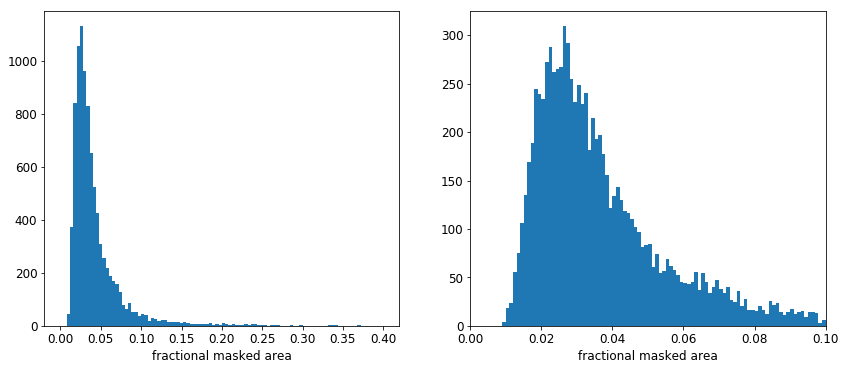

Density (per square degree):


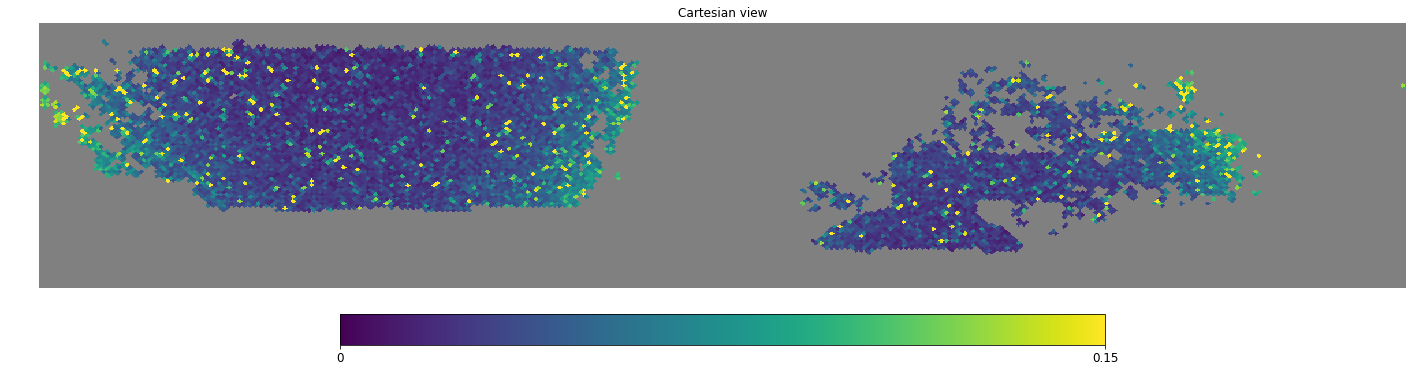

In [8]:
masked_frac = np.zeros(npix)  # fraction of masked area
hp_mask = m_all>(randoms_density*pix_area*min_pix_frac)
masked_frac[hp_mask] = m_masked[hp_mask]/m_all[hp_mask]
mplot = hp.ma(masked_frac)
mplot.mask = ~hp_mask

print('Median fraction of masked area: {:.2f}%'.format(np.median(masked_frac[hp_mask])*100))
mask = masked_frac[hp_mask]>0.2
print('Fraction of pixels with >20% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.1
print('Fraction of pixels with >10% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.075
print('Fraction of pixels with >7.5% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.05
print('Fraction of pixels with >5% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))

fig, ax = plt.subplots(1, 2, figsize=(14, 5.8))
ax[0].hist(masked_frac[hp_mask], range=(0, 0.4), bins=100)
ax[0].set_xlabel('fractional masked area')
ax[1].hist(masked_frac[hp_mask], range=(0, 0.1), bins=100)
ax[1].set_xlabel('fractional masked area')
ax[1].set_xlim(0, 0.1)
plt.show()

plt.figure(figsize=(25, 5))
hp.cartview(mplot, min=0, max=0.15, rot=(90, 0, 0), fig=1, latra=[-30, 40], xsize=1000, ysize=1000)

--------
## DR6

In [9]:
# Randoms
randoms = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim.fits'))
# WISE geometric mask
catmask = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim-wisemask.fits'))
# WISE pixel bitmask
pixmask = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim-pixmask.npy'))

In [10]:
# blobmask_bad = (randoms['MASKBITS'] & 2**1 > 0) # No BRIGHTSTARINBLOB
catmask_bad = np.copy(catmask['wisemask'])
# Pixel mask: not-primary and "resolved galaxy" are not masked
pixmask_bad = (pixmask!=0) & (pixmask!=(2**6)) & (pixmask!=(2**9))

__Individual masks__

In [11]:
# print('BRIGHTSTARINBLOB')
# print('Fraction of masked objects: {:.2f}%'.format(np.sum(blobmask_bad)/len(randoms)*100))
print('WISE geometric mask')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(catmask_bad)/len(randoms)*100))
print('WISE pixel bitmask')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(pixmask_bad)/len(randoms)*100))

WISE geometric mask
Fraction of masked objects: 2.79%
WISE pixel bitmask
Fraction of masked objects: 3.55%


__Combining the masks__

In [12]:
mask_bad = catmask_bad | pixmask_bad
print('WISE geometric + WISE pixel')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(randoms)*100))

WISE geometric + WISE pixel
Fraction of masked objects: 5.00%


In [14]:
print('BRIGHTSTARINBLOB + WISE geometric + WISE pixel')
mask_bad = catmask_bad | pixmask_bad

randoms_density = 10000 # per sq deg

# set minimum fraction of pixel area to be used
min_pix_frac = 0.5

nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print('NSIDE = {:};  pixel area = {:.4f} sq deg'.format(nside, pix_area))

# Assign all randoms to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, randoms['RA'], randoms['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m_all = np.zeros(npix)
m_all[pix_unique] = pix_count

# Assign masked randoms to healpix pixels
pix1 = hp.pixelfunc.ang2pix(nside, randoms['RA'][mask_bad], randoms['DEC'][mask_bad], lonlat=True)
pix_unique1, pix_count1 = np.unique(pix1, return_counts=True)
m_masked = np.zeros(npix)
m_masked[pix_unique1] = pix_count1

BRIGHTSTARINBLOB + WISE geometric + WISE pixel
NSIDE = 64;  pixel area = 0.8393 sq deg


Median fraction of masked area: 3.25%
Fraction of pixels with >20% masked area: 2.67%
Fraction of pixels with >10% masked area: 9.24%
Fraction of pixels with >7.5% masked area: 15.67%
Fraction of pixels with >5% masked area: 29.53%


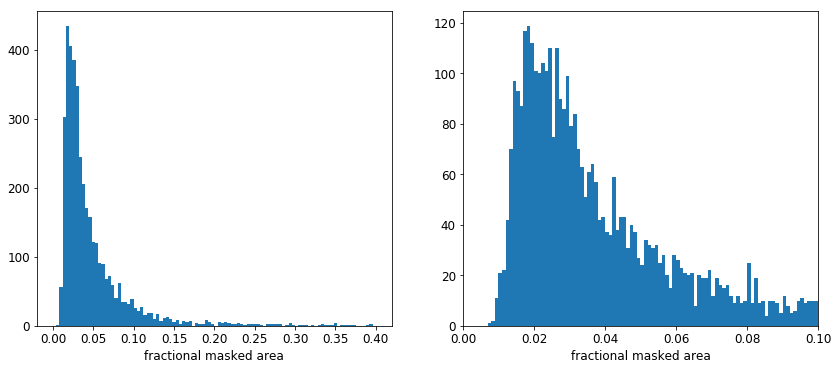

Density (per square degree):


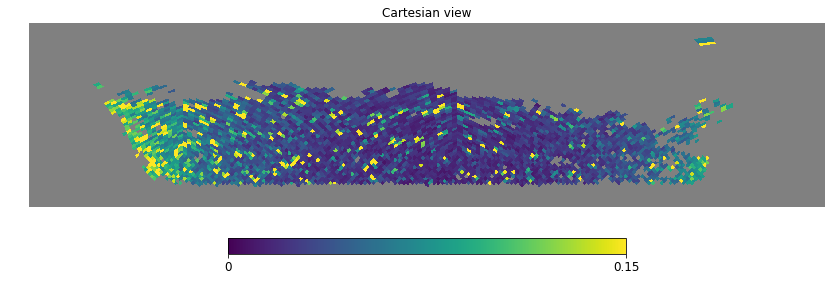

In [15]:
masked_frac = np.zeros(npix)  # fraction of masked area
hp_mask = m_all>(randoms_density*pix_area*min_pix_frac)
masked_frac[hp_mask] = m_masked[hp_mask]/m_all[hp_mask]
mplot = hp.ma(masked_frac)
mplot.mask = ~hp_mask

print('Median fraction of masked area: {:.2f}%'.format(np.median(masked_frac[hp_mask])*100))
mask = masked_frac[hp_mask]>0.2
print('Fraction of pixels with >20% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.1
print('Fraction of pixels with >10% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.075
print('Fraction of pixels with >7.5% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))
mask = masked_frac[hp_mask]>0.05
print('Fraction of pixels with >5% masked area: {:.2f}%'.format(np.sum(mask)/len(mask)*100))

fig, ax = plt.subplots(1, 2, figsize=(14, 5.8))
ax[0].hist(masked_frac[hp_mask], range=(0, 0.4), bins=100)
ax[0].set_xlabel('fractional masked area')
ax[1].hist(masked_frac[hp_mask], range=(0, 0.1), bins=100)
ax[1].set_xlabel('fractional masked area')
ax[1].set_xlim(0, 0.1)
plt.show()

plt.figure(figsize=(13, 6))
hp.cartview(mplot, min=0, max=0.15, rot=(180, 0, 0), fig=1, latra=[25, 85], lonra=[-120, 140], xsize=1000, ysize=1000)

-------
## Combine DR6 and DR7

DR7

In [16]:
# Randoms
randoms = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000.fits'))
# WISE geometric mask
catmask = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_wisemask.fits'))
# WISE pixel bitmask
pixmask = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_pixmask.npy'))

blobmask_bad = (randoms['MASKBITS'] & 2**1 > 0) # No BRIGHTSTARINBLOB
catmask_bad = np.copy(catmask['wisemask'])
# Pixel mask: not-primary and "resolved galaxy" are not masked
pixmask_bad = (pixmask!=0) & (pixmask!=(2**6)) & (pixmask!=(2**9))

##########################################################################################

mask_bad = blobmask_bad | catmask_bad | pixmask_bad

randoms_density = 10000 # per sq deg

# set minimum fraction of pixel area to be used
min_pix_frac = 0.5

nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print('NSIDE = {:};  pixel area = {:.4f} sq deg'.format(nside, pix_area))

# Assign all randoms to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, randoms['RA'], randoms['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m_all = np.zeros(npix)
m_all[pix_unique] = pix_count

# Assign masked randoms to healpix pixels
pix1 = hp.pixelfunc.ang2pix(nside, randoms['RA'][mask_bad], randoms['DEC'][mask_bad], lonlat=True)
pix_unique1, pix_count1 = np.unique(pix1, return_counts=True)
m_masked = np.zeros(npix)
m_masked[pix_unique1] = pix_count1

# fraction of masked area
masked_frac_dr7 = np.zeros(npix)
hp_mask_dr7 = m_all>(randoms_density*pix_area*min_pix_frac)
masked_frac_dr7[hp_mask_dr7] = m_masked[hp_mask_dr7]/m_all[hp_mask_dr7]

NSIDE = 64;  pixel area = 0.8393 sq deg


In [17]:
# Randoms
randoms = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim.fits'))
# WISE geometric mask
catmask = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim-wisemask.fits'))
# WISE pixel bitmask
pixmask = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr6.0/randoms/randoms-dr6.0-0.22.0-1-trim-pixmask.npy'))

# blobmask_bad = (randoms['MASKBITS'] & 2**1 > 0) # No BRIGHTSTARINBLOB
catmask_bad = np.copy(catmask['wisemask'])
# Pixel mask: not-primary and "resolved galaxy" are not masked
pixmask_bad = (pixmask!=0) & (pixmask!=(2**6)) & (pixmask!=(2**9))

##########################################################################################

mask_bad = catmask_bad | pixmask_bad

randoms_density = 10000 # per sq deg

# set minimum fraction of pixel area to be used
min_pix_frac = 0.5

nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print('NSIDE = {:};  pixel area = {:.4f} sq deg'.format(nside, pix_area))

# Assign all randoms to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, randoms['RA'], randoms['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m_all = np.zeros(npix)
m_all[pix_unique] = pix_count

# Assign masked randoms to healpix pixels
pix1 = hp.pixelfunc.ang2pix(nside, randoms['RA'][mask_bad], randoms['DEC'][mask_bad], lonlat=True)
pix_unique1, pix_count1 = np.unique(pix1, return_counts=True)
m_masked = np.zeros(npix)
m_masked[pix_unique1] = pix_count1

# fraction of masked area
masked_frac_dr6 = np.zeros(npix)
hp_mask_dr6 = m_all>(randoms_density*pix_area*min_pix_frac)
masked_frac_dr6[hp_mask_dr6] = m_masked[hp_mask_dr6]/m_all[hp_mask_dr6]

NSIDE = 64;  pixel area = 0.8393 sq deg


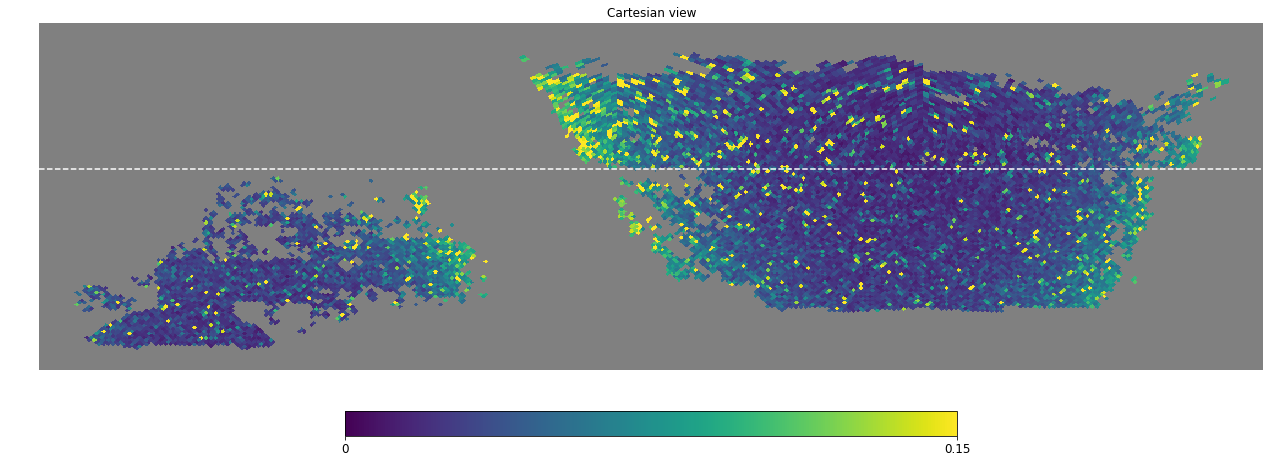

In [39]:
masked_frac = np.zeros(npix)
masked_frac[hp_mask_dr6] = masked_frac_dr6[hp_mask_dr6]
masked_frac[hp_mask_dr7] = masked_frac_dr7[hp_mask_dr7]
hp_mask = hp_mask_dr6 | hp_mask_dr7
mplot = hp.ma(masked_frac)
mplot.mask = ~hp_mask

plt.figure(figsize=(20, 8))
hp.cartview(mplot, min=0, max=0.15, rot=(260, 0, 0), fig=1, latra=[-27, 75], xsize=1000, ysize=1000)
plt.grid()
plt.axhline(32, color='white', ls='--')
plt.show()